# FunUQ for MD
## Sam Reeve and Alejandro Strachan
### Replication of: Reeve, S. T. & Strachan, A. Quantifying uncertainties originating from interatomic potentials in molecular dynamics. (Submitted to Modell. Simul. Mater. Sci. Eng. 2018).
### NPT Morse / Exponential-6 at 1500K and 1 GPa (Pre-run simulations)

#### This notebook goes through all steps of functional uncertainty quantification FunUQ for interatomic potential in molecular dynamics, matching one case from the paper. The main steps are: 
 * Define folders, simulation system, and models
 * (Run simulations)
 * Calculate functional derivatives
 * Calculate correction for quantities of interest due to changing from one function to another

In [1]:
import sys, os, numpy as np
# Relative path from notebook to module
sys.path.insert(0, '../../lib/')
sys.path.insert(0, '../../lib/FunUQ/')

In [2]:
# Import FunUQ module
from FunUQ import *

# Provides access to nanoHUB simulation codes (LAMMPS)
from hublib import use

# Utility functions (Austin Zadoks)
from nH_utils import *

In [3]:
# Only needed if using submit
% use lammps-09Dec14
# Only needed if interacting with plots
% matplotlib notebook

In [4]:
# "True" will run new simulations below
# Change after first usage to only analyze results
run_main = False
run_verify = False
run_perturb = False
run_bruteforce = False

## System setup: define interatomic potentials and quantities of interest

In [5]:
rundir = os.getcwd()
startdir = os.path.abspath(os.path.join(rundir, 'init/'))

mainname = 'main' # morse
correctname = 'exp6'

In [6]:
Pot_main = Potential('morse', paramdir=startdir, create=True, N=7000, rmax=7.0, cut=6.0)
Pot_correct = Potential('exp6', paramdir=startdir, create=True, N=7000, rmax=7.0, cut=6.0)

In [7]:
QoI_list = ['PotEng', 'Volume']
Nqoi = len(QoI_list)
QoI_dict = {'description': 'Replication of Reeve and Strachan, (Submitted 2018)',
            'Ncopies': 2,
            'units': ['eV/atom', 'nm$^3$'],
            #'overwrite': True, 
           }

In [8]:
QoI = QuantitiesOfInterest(QoI_list, Pot_main,
                           startdir, rundir, mainname, 'metal',
                           input_dict=QoI_dict)
QoI_correct = QuantitiesOfInterest(QoI_list, Pot_correct,
                                   startdir, rundir, correctname, 'metal',
                                   input_dict=QoI_dict)

<IPython.core.display.Javascript object>


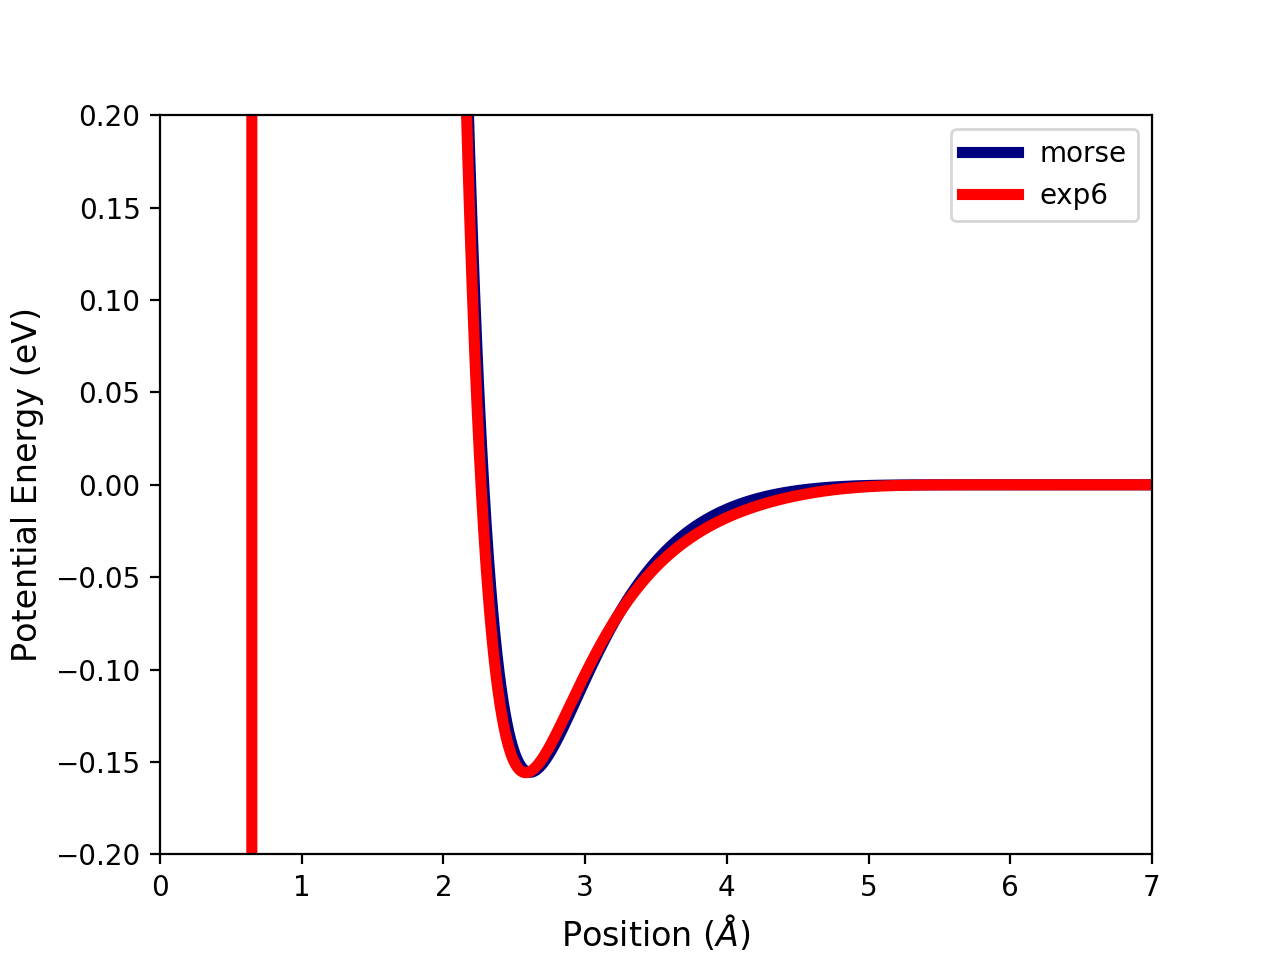

In [9]:
ax1 = Pot_main.plot()
ax1 = Pot_correct.plot(ax=ax1, color='red', unit=QoI.PE_units)

#### Compare the plot above to Reeve & Strachan (Submitted to MSMSE 2018), Figure 1

## Run simulations or extract results

In [10]:
if run_main:
    QoI.run_lammps(mode='nanoHUB_submit') # 'nanoHUB_local'
if run_verify:
    QoI_correct.run_lammps(mode='nanoHUB_submit')

In [11]:
#submit_status()
local_status(rundir, [mainname, correctname])

The following may not be accurate with remote running jobs
This counts only jobs which have started/finished with files copied

Status for main
   * 2 Folders with running/unfinished runs
Status for exp6
   * 2 Folders with running/unfinished runs


In [12]:
#kill_jobs('06829511') # Use RunName

In [13]:
QoI.extract_lammps()
QoI_correct.extract_lammps()
print(QoI); print(QoI_correct)

PotEng	Volume
-0.666	13.869	

PotEng	Volume
-0.729	13.147	



## Calculate functional derivatives

In [14]:
FD_dict = {'alist': [-1e-8, -2e-8, 1e-8, 2e-8],
          }

In [15]:
FuncDer = FuncDer_perturb_coord(QoI, Pot_main, ensemble='npt',
                                 input_dict=FD_dict)

In [16]:
if run_bruteforce and FuncDer.method == 'bruteforce':
    FuncDer.run_lammps()
elif run_perturb and FuncDer.method == 'perturbative_allatom':
    FuncDer.rerun_gauss()

Calculated perturbations
Extracted RDF data for copy 0
Extracted RDF data for copy 1
Calculated perturbation Hamiltonian contributions
Calculated exponential weights
Calculated functional derivatives



<IPython.core.display.Javascript object>


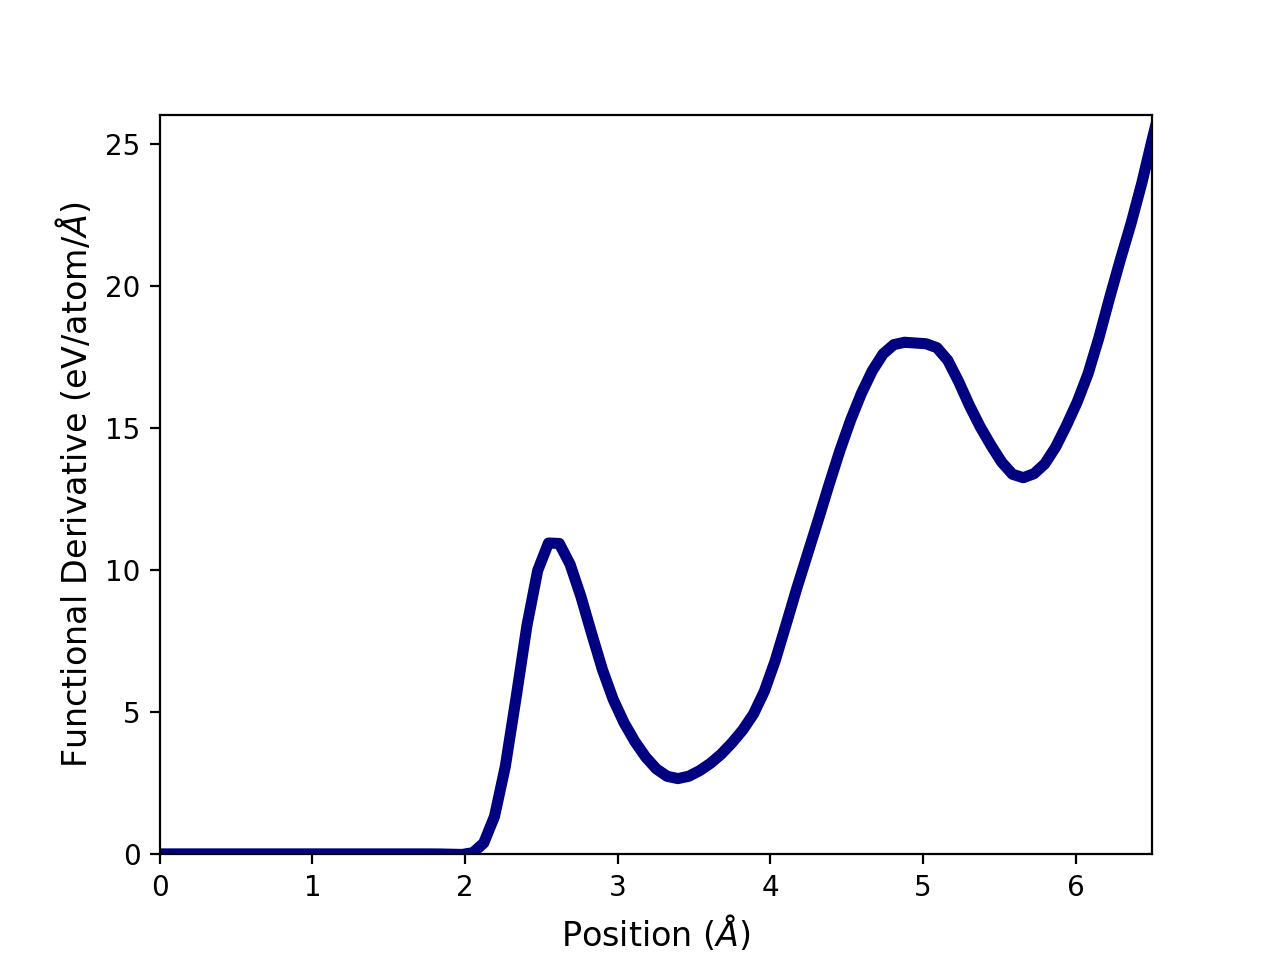

<IPython.core.display.Javascript object>


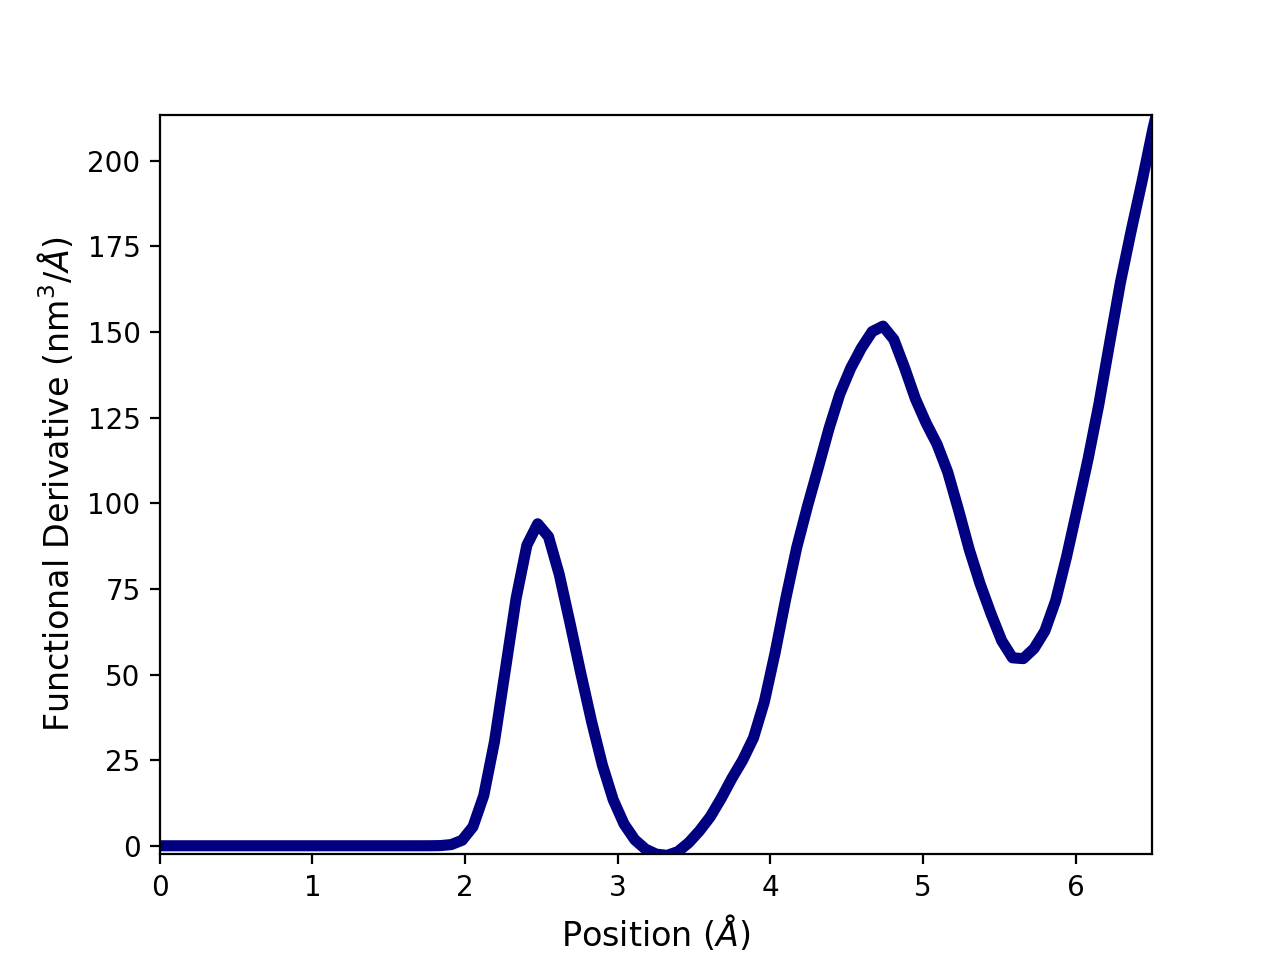

In [17]:
FuncDer.prepare_FD()
FuncDer.calc_FD()
for x in range(Nqoi):
    FuncDer.write_FD(x)
    FuncDer.plot_FD(x)

#### Compare the plot for volume to Reeve & Strachan (Submitted to MSMSE 2018), Figure 2a

## Correct quantities of interest

In [18]:
Correct = FunUQ(Pot_main, Pot_correct, QoI.Q_names, QoI.Qavg, QoI_correct.Qavg, PE_units=QoI.PE_units,
                Q_units=QoI.units, FD=FuncDer.funcder, R=FuncDer.rlist)

Calculated discrepancy



<IPython.core.display.Javascript object>


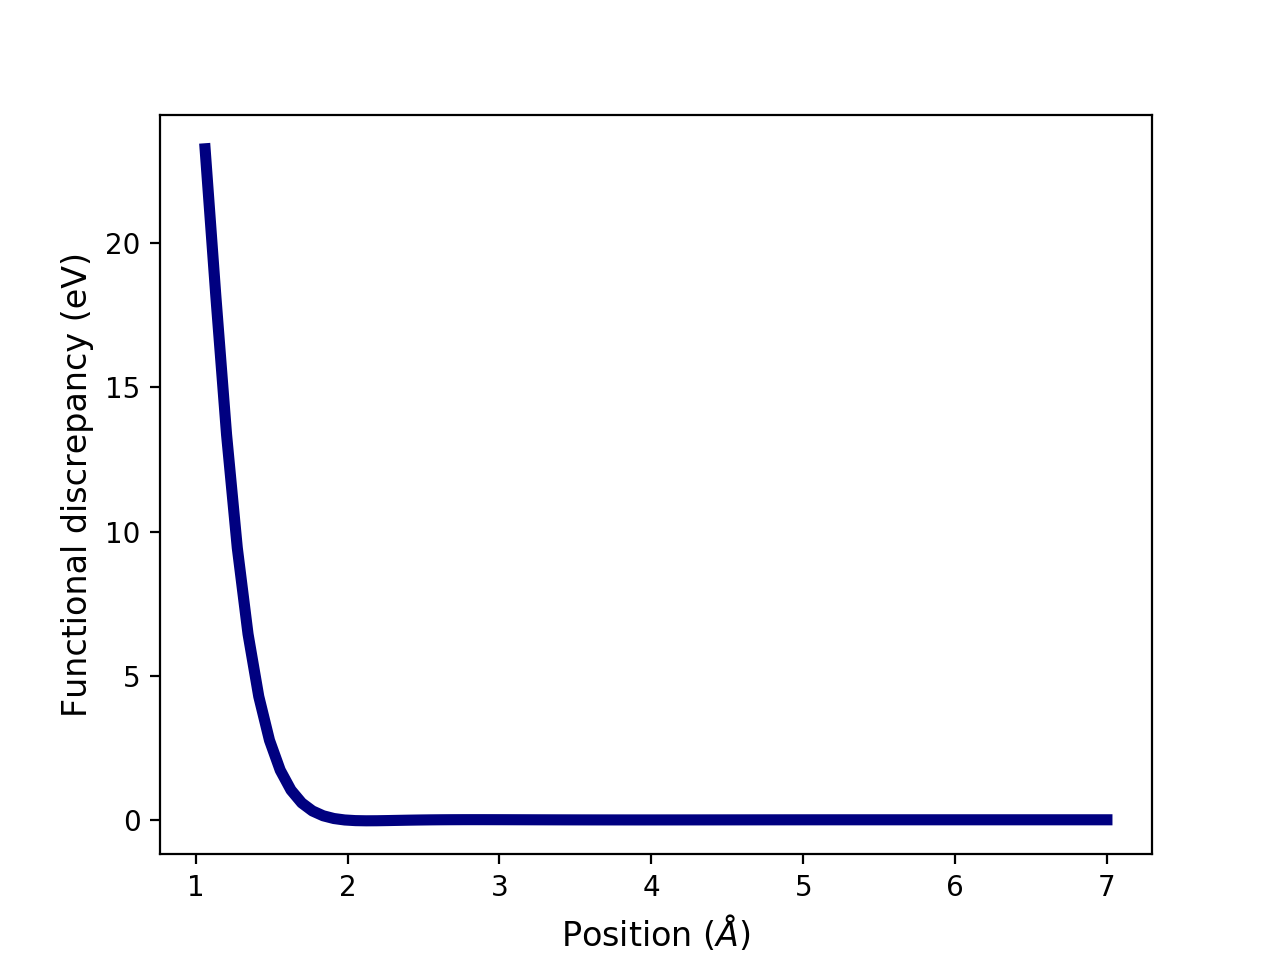

In [19]:
Correct.discrepancy()
Correct.plot_discrep()

#### Compare the plot above to Reeve & Strachan (Submitted to MSMSE 2018), Figure 2b

In [20]:
Correct.correct()

Calculated correction terms
***** PotEng *****
FunUQ		 FunUQ		 Direct		 Main		 Correction
% error		 correction	 simulation	 QoI		 QoI
-0.34%		 -6.546e-02	 -6.299e-02	 -6.662e-01	 -7.292e-01

***** Volume *****
FunUQ		 FunUQ		 Direct		 Main		 Correction
% error		 correction	 simulation	 QoI		 QoI
0.33%		 -7.657e-01	 -7.224e-01	 1.387e+01	 1.315e+01



<IPython.core.display.Javascript object>


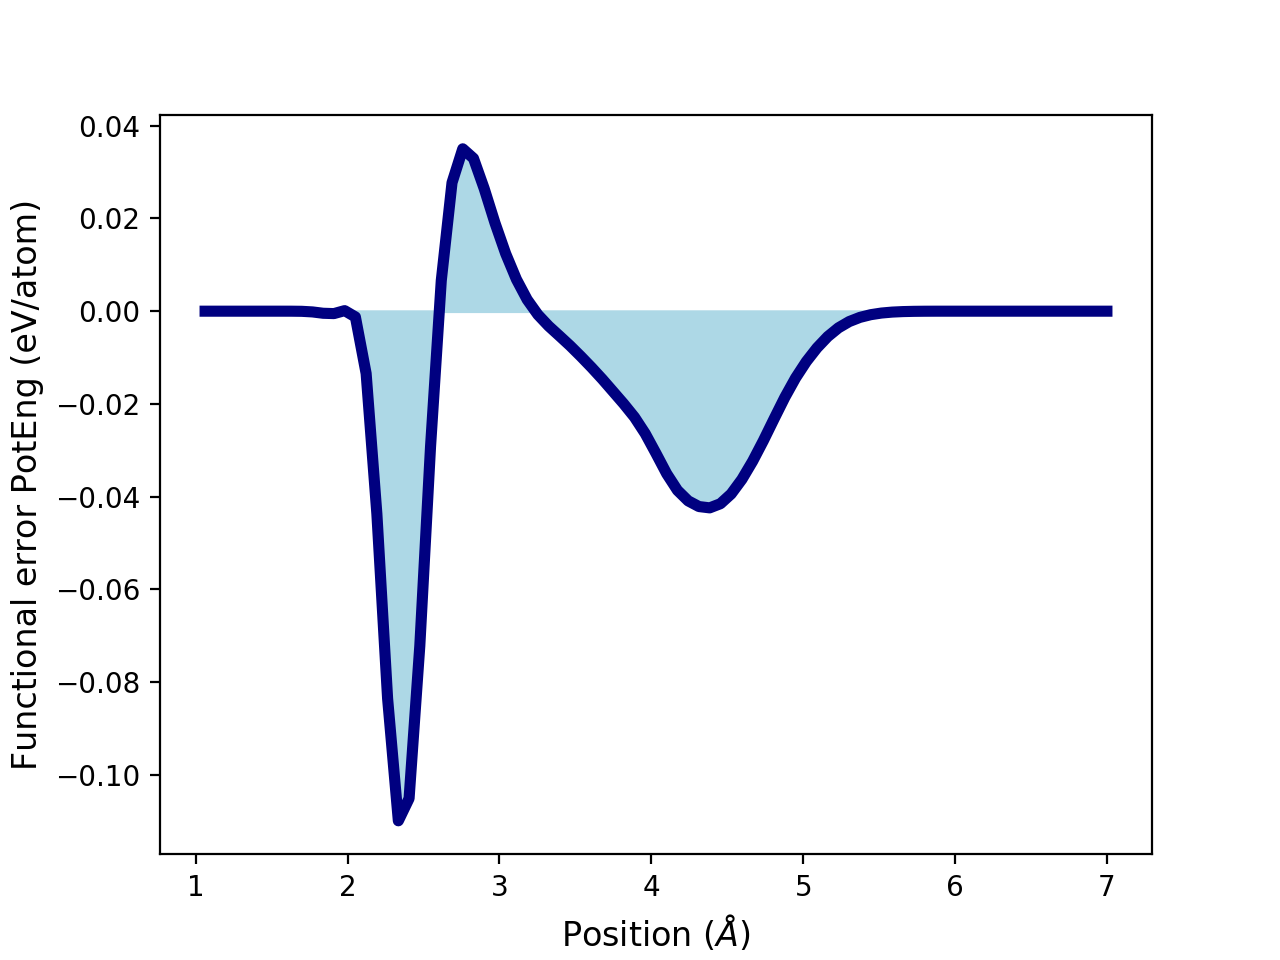

<IPython.core.display.Javascript object>


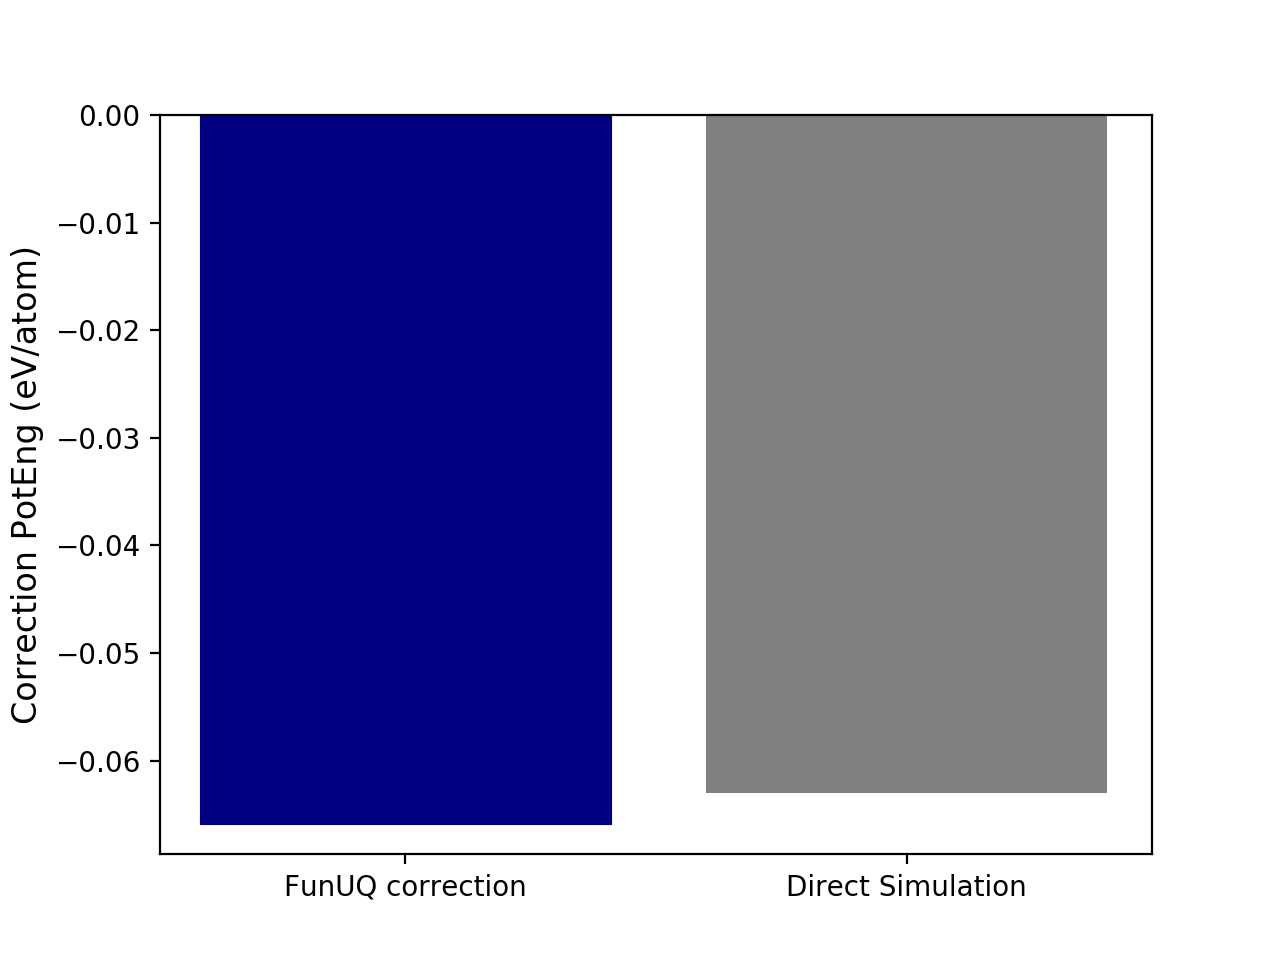

<IPython.core.display.Javascript object>


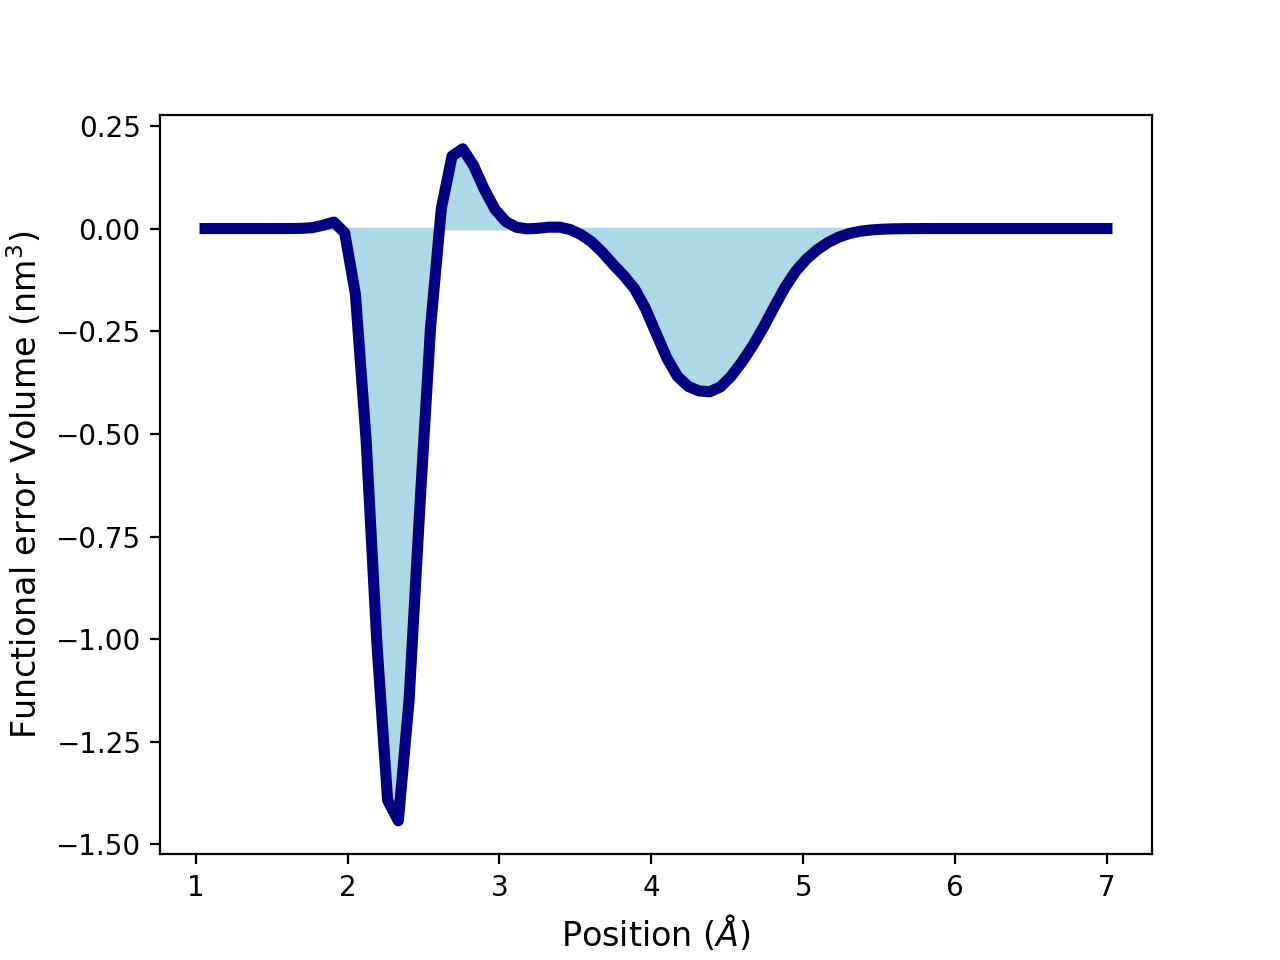

<IPython.core.display.Javascript object>


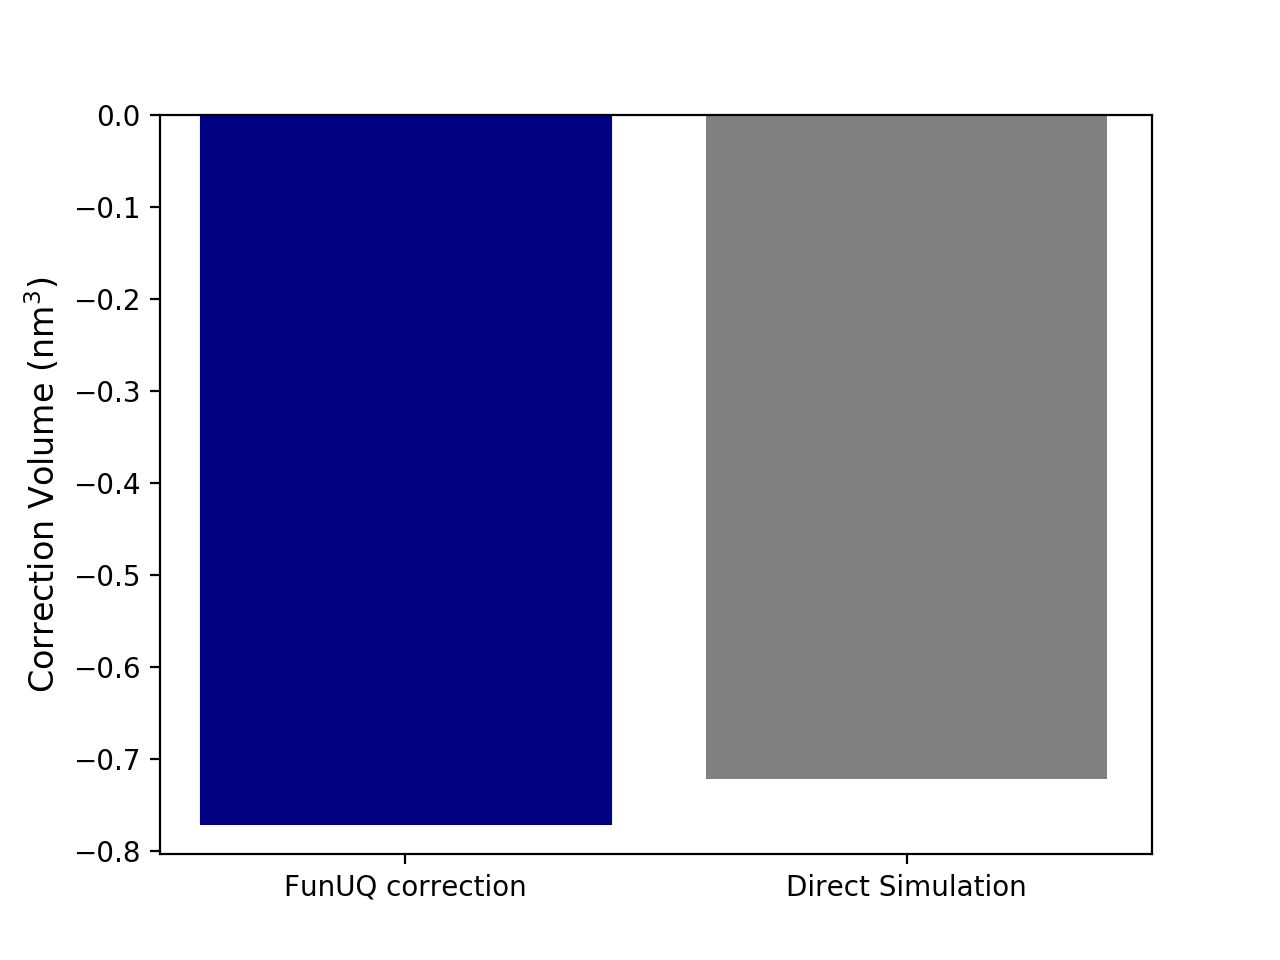

In [21]:
for x in range(Nqoi):
    Correct.plot_funcerr(x)
    Correct.plot_correction(x)

#### Compare the plot for volume to Reeve & Strachan (Submitted to MSMSE 2018), Figure 2c